In [47]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import FastICA, PCA
from scipy.signal import find_peaks

from scipy.signal import find_peaks, welch
from scipy.stats import pearsonr


In [48]:
# Root directory of your dataset
base_dir = './'  # Adjust if needed
output_dir = 'combined_signals'  # Save mixed signals here

os.makedirs(output_dir, exist_ok=True)

# Subdirectory and levels
subdirectory = [f"sub{str(i).zfill(2)}" for i in range(1, 11)]
levels = [f"l{i}" for i in range(1, 6)]



Combination 1 = 0.8 mecg + 0.2 fecg + noise 1
Combination 2 = 0.8 fecg + 0.2 mecg + noise 2 

In [49]:
# Iterate through subdirectory and levels
for sub in subdirectory:
    for level in levels:
        prefix = f"{sub}_snr00dB_{level}_c0"
        print(f"Processing: {prefix}")

        sub_folder = os.path.join(base_dir, sub, level)

        try:
            # Read the signals
            fecg = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_fecg1"))
            mecg = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_mecg"))
            noise1 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise1"))
            noise2 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise2"))

            # Extract the signals (first column of each)
            f_ecg = fecg.p_signal[:, 0]
            m_ecg = mecg.p_signal[:, 0]
            n1 = noise1.p_signal[:, 0]
            n2 = noise2.p_signal[:, 0]

            # Ensure they all have the same length
            min_len = min(len(f_ecg), len(m_ecg), len(n1), len(n2))
            f_ecg = f_ecg[:min_len]
            m_ecg = m_ecg[:min_len]
            n1 = n1[:min_len]
            n2 = n2[:min_len]

            # Create the combinations
            combination1 = 0.8 * m_ecg + 0.2 * f_ecg + 0.05 * n1
            combination2 = 0.8 * f_ecg + 0.2 * m_ecg + 0.05 * n2

            # Save Combination 1
            record_name1 = f"{sub}_{level}_c0_combination1"
            wfdb.wrsamp(
                record_name=record_name1,
                fs=fecg.fs,
                units=['mV'],  # Unit for the signal
                sig_name=['combination1'],
                p_signal=combination1.reshape(-1, 1)  # Reshape to 2D array
            )
            os.replace(
                f"{record_name1}.hea",
                os.path.join(output_dir, f"{record_name1}.hea")
            )
            os.replace(
                f"{record_name1}.dat",
                os.path.join(output_dir, f"{record_name1}.dat")
            )

            # Save Combination 2
            record_name2 = f"{sub}_{level}_c0_combination2"
            wfdb.wrsamp(
                record_name=record_name2,
                fs=fecg.fs,
                units=['mV'],  # Unit for the signal
                sig_name=['combination2'],
                p_signal=combination2.reshape(-1, 1)  # Reshape to 2D array
            )
            os.replace(
                f"{record_name2}.hea",
                os.path.join(output_dir, f"{record_name2}.hea")
            )
            os.replace(
                f"{record_name2}.dat",
                os.path.join(output_dir, f"{record_name2}.dat")
            )

            print(f"Saved Combination 1 to {record_name1}.hea / .dat")
            print(f"Saved Combination 2 to {record_name2}.hea / .dat")

        except Exception as e:
            print(f"Error processing {prefix}: {e}")

Processing: sub01_snr00dB_l1_c0
Saved Combination 1 to sub01_l1_c0_combination1.hea / .dat
Saved Combination 2 to sub01_l1_c0_combination2.hea / .dat
Processing: sub01_snr00dB_l2_c0
Saved Combination 1 to sub01_l2_c0_combination1.hea / .dat
Saved Combination 2 to sub01_l2_c0_combination2.hea / .dat
Processing: sub01_snr00dB_l3_c0
Saved Combination 1 to sub01_l3_c0_combination1.hea / .dat
Saved Combination 2 to sub01_l3_c0_combination2.hea / .dat
Processing: sub01_snr00dB_l4_c0
Saved Combination 1 to sub01_l4_c0_combination1.hea / .dat
Saved Combination 2 to sub01_l4_c0_combination2.hea / .dat
Processing: sub01_snr00dB_l5_c0
Saved Combination 1 to sub01_l5_c0_combination1.hea / .dat
Saved Combination 2 to sub01_l5_c0_combination2.hea / .dat
Processing: sub02_snr00dB_l1_c0
Saved Combination 1 to sub02_l1_c0_combination1.hea / .dat
Saved Combination 2 to sub02_l1_c0_combination2.hea / .dat
Processing: sub02_snr00dB_l2_c0
Saved Combination 1 to sub02_l2_c0_combination1.hea / .dat
Saved Com

Step 2: Plot combined signal and separated signals 

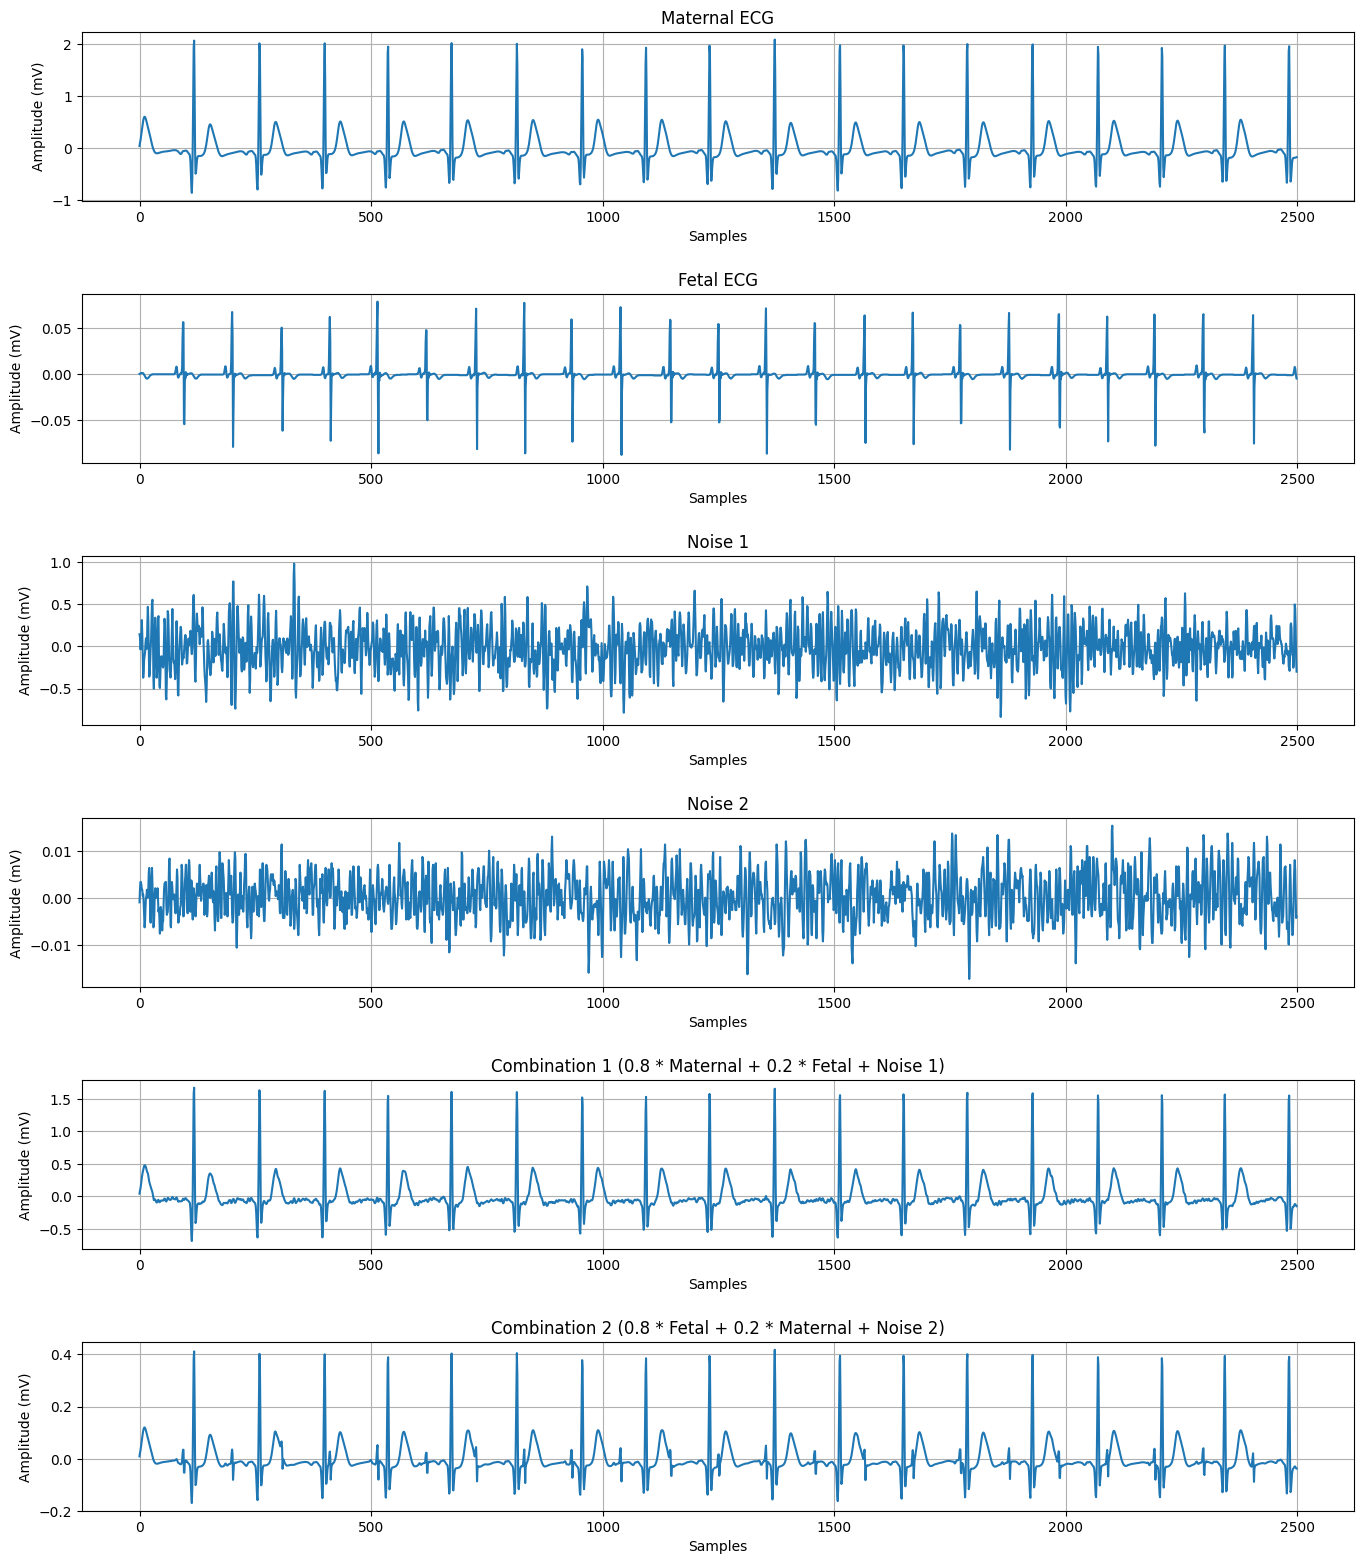

In [50]:


# Setup
subject = "sub01"
level = "l1"
base_dir = "./"
prefix = f"{subject}_snr00dB_{level}_c0"
sub_folder = os.path.join(base_dir, subject, level)

# Load original individual signals
fetal = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_fecg1"))
maternal = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_mecg"))
noise1 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise1"))
noise2 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise2"))

# Extract and trim
fs = fetal.fs
seconds = 10
samples_to_plot = int(seconds * fs)

f_ecg = fetal.p_signal[:, 0][:samples_to_plot]
m_ecg = maternal.p_signal[:, 0][:samples_to_plot]
n1 = noise1.p_signal[:, 0][:samples_to_plot]
n2 = noise2.p_signal[:, 0][:samples_to_plot]

# Load combinations
combination1_path = os.path.join('combined_signals', f"{subject}_{level}_c0_combination1")
combination2_path = os.path.join('combined_signals', f"{subject}_{level}_c0_combination2")

combination1 = wfdb.rdrecord(combination1_path).p_signal[:, 0][:samples_to_plot]
combination2 = wfdb.rdrecord(combination2_path).p_signal[:, 0][:samples_to_plot]

# Plot original signals
labels = ['Maternal ECG', 'Fetal ECG', 'Noise 1', 'Noise 2']
signals = [m_ecg, f_ecg, n1, n2]

plt.figure(figsize=(14, 16))
for i, sig in enumerate(signals):
    plt.subplot(6, 1, i + 1)
    plt.plot(sig)
    plt.title(labels[i])
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.grid()

# Plot combinations
plt.subplot(6, 1, 5)
plt.plot(combination1)
plt.title("Combination 1 (0.8 * Maternal + 0.2 * Fetal + Noise 1)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid()

plt.subplot(6, 1, 6)
plt.plot(combination2)
plt.title("Combination 2 (0.8 * Fetal + 0.2 * Maternal + Noise 2)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid()

plt.tight_layout(pad=2)
plt.show()

Step 3: Apply FastICA for Blind Source Separation

In [51]:


# Paths for combined signals and ICA output
combined_dir = 'combined_signals'
ica_output_dir = 'ica_outputs'
os.makedirs(ica_output_dir, exist_ok=True)

# Subdirectory and levels
subdirectory = [f"sub{str(i).zfill(2)}" for i in range(1, 11)]
levels = [f"l{i}" for i in range(1, 6)]

for sub in subdirectory:
    for level in levels:
        try:
            # Load Combination 1 and Combination 2
            combination1_path = os.path.join(combined_dir, f"{sub}_{level}_c0_combination1")
            combination2_path = os.path.join(combined_dir, f"{sub}_{level}_c0_combination2")

            combination1 = wfdb.rdrecord(combination1_path).p_signal[:, 0]
            combination2 = wfdb.rdrecord(combination2_path).p_signal[:, 0]

            # Ensure both combinations have the same length
            min_len = min(len(combination1), len(combination2))
            combination1 = combination1[:min_len]
            combination2 = combination2[:min_len]

            # Stack the two combinations into a 2-channel signal
            mixed_signals = np.stack([combination1, combination2], axis=1)

            # Apply ICA with 2 components
            ica = FastICA(n_components=2, random_state=0)
            separated_signals = ica.fit_transform(mixed_signals)

            # Rescale the independent components to match the original signal range
            scaling_factor = np.std(mixed_signals, axis=0) / np.std(separated_signals, axis=0)
            rescaled_components = separated_signals * scaling_factor

            # Save the separated components as a NumPy array
            record_name = f"{sub}_{level}_c0_ica"
            output_file = os.path.join(ica_output_dir, f"{record_name}.npy")
            np.save(output_file, rescaled_components)

            print(f"Saved ICA output to {output_file}")

        except Exception as e:
            print(f"Error processing {sub}_{level}: {e}")

Saved ICA output to ica_outputs/sub01_l1_c0_ica.npy
Saved ICA output to ica_outputs/sub01_l2_c0_ica.npy
Saved ICA output to ica_outputs/sub01_l3_c0_ica.npy
Saved ICA output to ica_outputs/sub01_l4_c0_ica.npy
Saved ICA output to ica_outputs/sub01_l5_c0_ica.npy
Saved ICA output to ica_outputs/sub02_l1_c0_ica.npy
Saved ICA output to ica_outputs/sub02_l2_c0_ica.npy
Saved ICA output to ica_outputs/sub02_l3_c0_ica.npy
Saved ICA output to ica_outputs/sub02_l4_c0_ica.npy
Saved ICA output to ica_outputs/sub02_l5_c0_ica.npy
Saved ICA output to ica_outputs/sub03_l1_c0_ica.npy
Saved ICA output to ica_outputs/sub03_l2_c0_ica.npy
Saved ICA output to ica_outputs/sub03_l3_c0_ica.npy
Saved ICA output to ica_outputs/sub03_l4_c0_ica.npy
Saved ICA output to ica_outputs/sub03_l5_c0_ica.npy
Saved ICA output to ica_outputs/sub04_l1_c0_ica.npy
Saved ICA output to ica_outputs/sub04_l2_c0_ica.npy
Saved ICA output to ica_outputs/sub04_l3_c0_ica.npy
Saved ICA output to ica_outputs/sub04_l4_c0_ica.npy
Saved ICA ou

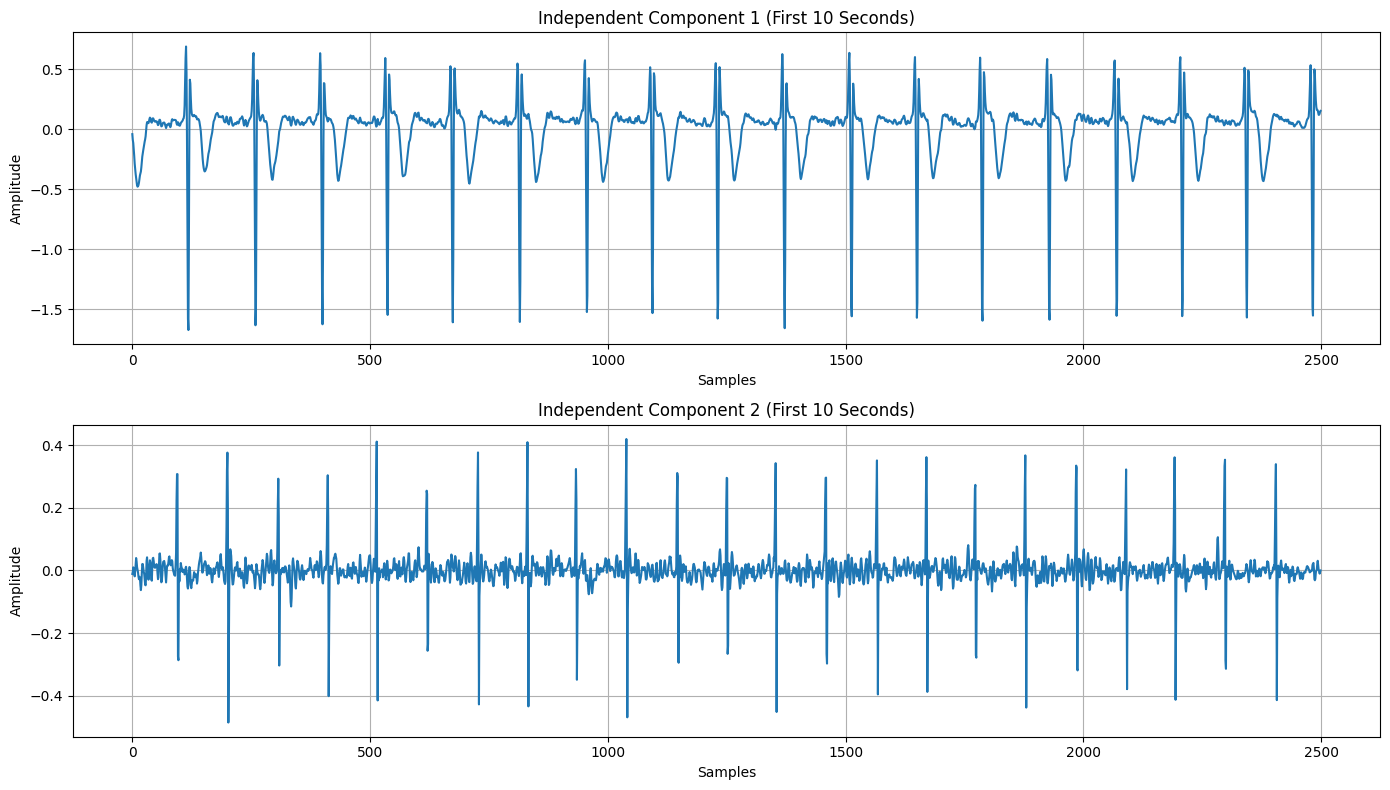

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Paths for ICA output
ica_output_dir = 'ica_outputs'

# Setup
subject = "sub01"
level = "l1"
record_name = f"{subject}_{level}_c0_ica"

# Load the saved independent components
ica_file_path = os.path.join(ica_output_dir, f"{record_name}.npy")
if os.path.exists(ica_file_path):
    separated_signals = np.load(ica_file_path)

    # Define the number of samples to plot
    seconds = 10  # Adjust as needed
    fs = 250  # Replace with the actual sampling frequency if known
    samples_to_plot = int(seconds * fs)

    # Trim the independent components to the desired number of samples
    separated_signals = separated_signals[:samples_to_plot]

    # Plot the two independent components
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(separated_signals[:, 0])
    plt.title("Independent Component 1 (First 10 Seconds)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(separated_signals[:, 1])
    plt.title("Independent Component 2 (First 10 Seconds)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid()

    plt.tight_layout()
    plt.show()
else:
    print(f"ICA file not found: {ica_file_path}")

Step 4: Evaluation of Separation for all 50 signals 
- Heart rate estimation and comparation against ground truth .qrs annotations
- Correlation with ground truth signals

In [53]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import pearsonr

# Directories
base_dir = './'
combined_dir = 'combined_signals'
ica_output_dir = 'ica_outputs'
results_dir = 'ica_analysis_results'
cleaned_dir = 'ica_cleaned_signals'
plot_dir = 'ecg_cleaned_plots'

os.makedirs(results_dir, exist_ok=True)
os.makedirs(cleaned_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Subdirectories and levels
subdirectory = [f"sub{str(i).zfill(2)}" for i in range(1, 11)]
levels = [f"l{i}" for i in range(1, 6)]

# Function to compute heart rate
def compute_hr(peaks, fs):
    rr_intervals = np.diff(peaks) / fs
    return 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0

# Iterate through all subjects and levels
for sub in subdirectory:
    for level in levels:
        record_base = f"{sub}_snr00dB_{level}_c0"
        print(f"Analyzing: {sub}_{level}")

        try:
            # Load ICA components
            ica_path = os.path.join(ica_output_dir, f"{sub}_{level}_c0_ica.npy")
            separated = np.load(ica_path)

            # Load the sampling frequency from one of the combined signals
            combination1_path = os.path.join(combined_dir, f"{sub}_{level}_c0_combination1")
            combination1_rec = wfdb.rdrecord(combination1_path)
            fs = combination1_rec.fs

            # Load original signals (ground truth for comparison)
            sub_folder = os.path.join(base_dir, sub, level)
            fetal = wfdb.rdrecord(os.path.join(sub_folder, f"{record_base}_fecg1"))
            maternal = wfdb.rdrecord(os.path.join(sub_folder, f"{record_base}_mecg"))
            f_ecg = fetal.p_signal[:, 0]
            m_ecg = maternal.p_signal[:, 0]
            min_len = min(len(f_ecg), len(separated))
            f_ecg = f_ecg[:min_len]
            m_ecg = m_ecg[:min_len]
            separated = separated[:min_len]

            # Load QRS annotations
            fecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{record_base}_fecg1"), 'qrs')
            mecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{record_base}_mecg"), 'qrs')
            fecg_rpeaks = fecg_ann.sample
            mecg_rpeaks = mecg_ann.sample

            # Compute ground truth HR
            true_fecg_hr = compute_hr(fecg_rpeaks, fs)
            true_mecg_hr = compute_hr(mecg_rpeaks, fs)

            # Prepare output file
            result_file = os.path.join(results_dir, f"{sub}_{level}_analysis.txt")
            with open(result_file, 'w') as f:
                f.write(f"=== Analysis: {sub}_{level} ===\n")
                f.write(f"Sampling Frequency: {fs} Hz\n")
                f.write(f"True Fetal HR:    {true_fecg_hr:.1f} bpm\n")
                f.write(f"True Maternal HR: {true_mecg_hr:.1f} bpm\n\n")

                correlations_f = []
                correlations_m = []

                for i in range(separated.shape[1]):
                    signal = separated[:, i]
                    peaks, _ = find_peaks(signal, distance=fs * 0.4)
                    hr = compute_hr(peaks, fs)

                    corr_f, p_value_f = pearsonr(signal, f_ecg)
                    corr_m, p_value_m = pearsonr(signal, m_ecg)

                    correlations_f.append((corr_f, p_value_f, i))
                    correlations_m.append((corr_m, p_value_m, i))

                    f.write(f"--- Component {i+1} ---\n")
                    f.write(f"Estimated HR: {hr:.1f} bpm\n")
                    f.write(f"Correlation with Fetal ECG:    r = {corr_f:.3f}, p = {p_value_f:.3e}\n")
                    f.write(f"Correlation with Maternal ECG: r = {corr_m:.3f}, p = {p_value_m:.3e}\n\n")

                    

                # Select best fetal component
                valid_fetal_components = [x for x in correlations_f if x[1] < 0.05]
                if valid_fetal_components:
                    best_fetal_idx = max(valid_fetal_components, key=lambda x: abs(x[0]))[2]
                else:
                    best_fetal_idx = max(correlations_f, key=lambda x: abs(x[0]))[2]

                # Select best maternal component
                valid_maternal_components = [x for x in correlations_m if x[1] < 0.05]
                if valid_maternal_components:
                    best_maternal_idx = max(valid_maternal_components, key=lambda x: abs(x[0]))[2]
                else:
                    best_maternal_idx = max(correlations_m, key=lambda x: abs(x[0]))[2]

                f.write(f"Selected Fetal Component:    {best_fetal_idx + 1}\n")
                f.write(f"Selected Maternal Component: {best_maternal_idx + 1}\n")

            # Save cleaned signals
            cleaned_fecg = separated[:, best_fetal_idx]
            cleaned_mecg = separated[:, best_maternal_idx]

            np.save(os.path.join(cleaned_dir, f"{sub}_{level}_cleaned_fecg.npy"), cleaned_fecg)
            np.save(os.path.join(cleaned_dir, f"{sub}_{level}_cleaned_mecg.npy"), cleaned_mecg)

            # Plot cleaned fetal ECG
            plt.figure(figsize=(12, 4))
            duration_sec = 3
            samples_to_plot = int(fs * duration_sec)
            plt.plot(np.arange(samples_to_plot) / fs, cleaned_fecg[:samples_to_plot], color='blue')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.xticks(np.arange(0, duration_sec + 0.5, 0.5))
            plt.title(f"Cleaned Fetal ECG - {sub}_{level}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            fecg_plot_path = os.path.join(plot_dir, f"{sub}_{level}_cleaned_fecg.png")
            plt.savefig(fecg_plot_path)
            plt.close()

            # Plot cleaned maternal ECG
            plt.figure(figsize=(12, 4))
            plt.plot(np.arange(samples_to_plot) / fs, cleaned_mecg[:samples_to_plot], color='blue')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.xticks(np.arange(0, duration_sec + 0.5, 0.5))
            plt.title(f"Cleaned Maternal ECG - {sub}_{level}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            mecg_plot_path = os.path.join(plot_dir, f"{sub}_{level}_cleaned_mecg.png")
            plt.savefig(mecg_plot_path)
            plt.close()

            print(f"Saved: {result_file}")
            print(f"Saved cleaned fetal and maternal ECG for {sub}_{level}")

        except Exception as e:
            print(f"Error processing {sub}_{level}: {e}")

Analyzing: sub01_l1
Saved: ica_analysis_results/sub01_l1_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l1
Analyzing: sub01_l2
Saved: ica_analysis_results/sub01_l2_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l2
Analyzing: sub01_l3
Saved: ica_analysis_results/sub01_l3_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l3
Analyzing: sub01_l4
Saved: ica_analysis_results/sub01_l4_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l4
Analyzing: sub01_l5
Saved: ica_analysis_results/sub01_l5_analysis.txt
Saved cleaned fetal and maternal ECG for sub01_l5
Analyzing: sub02_l1
Saved: ica_analysis_results/sub02_l1_analysis.txt
Saved cleaned fetal and maternal ECG for sub02_l1
Analyzing: sub02_l2
Saved: ica_analysis_results/sub02_l2_analysis.txt
Saved cleaned fetal and maternal ECG for sub02_l2
Analyzing: sub02_l3
Saved: ica_analysis_results/sub02_l3_analysis.txt
Saved cleaned fetal and maternal ECG for sub02_l3
Analyzing: sub02_l4
Saved: ica_analysis_

Just an example of what is done in step 3 and 4 on signals from Sub01 and L1 


--- Ground Truth Heart Rates ---
Fetal HR:    143.0 bpm
Maternal HR: 107.8 bpm

--- ICA Component HR Estimation ---
Component 1: HR ≈ 107.8 bpm
Component 2: HR ≈ 141.8 bpm

--- Correlation with Ground Truth Signals ---

Component 1:
  Correlation with Maternal ECG: r = -0.999
  Correlation with Fetal ECG: r = -0.007

Component 2:
  Correlation with Maternal ECG: r = 0.012
  Correlation with Fetal ECG: r = 0.928


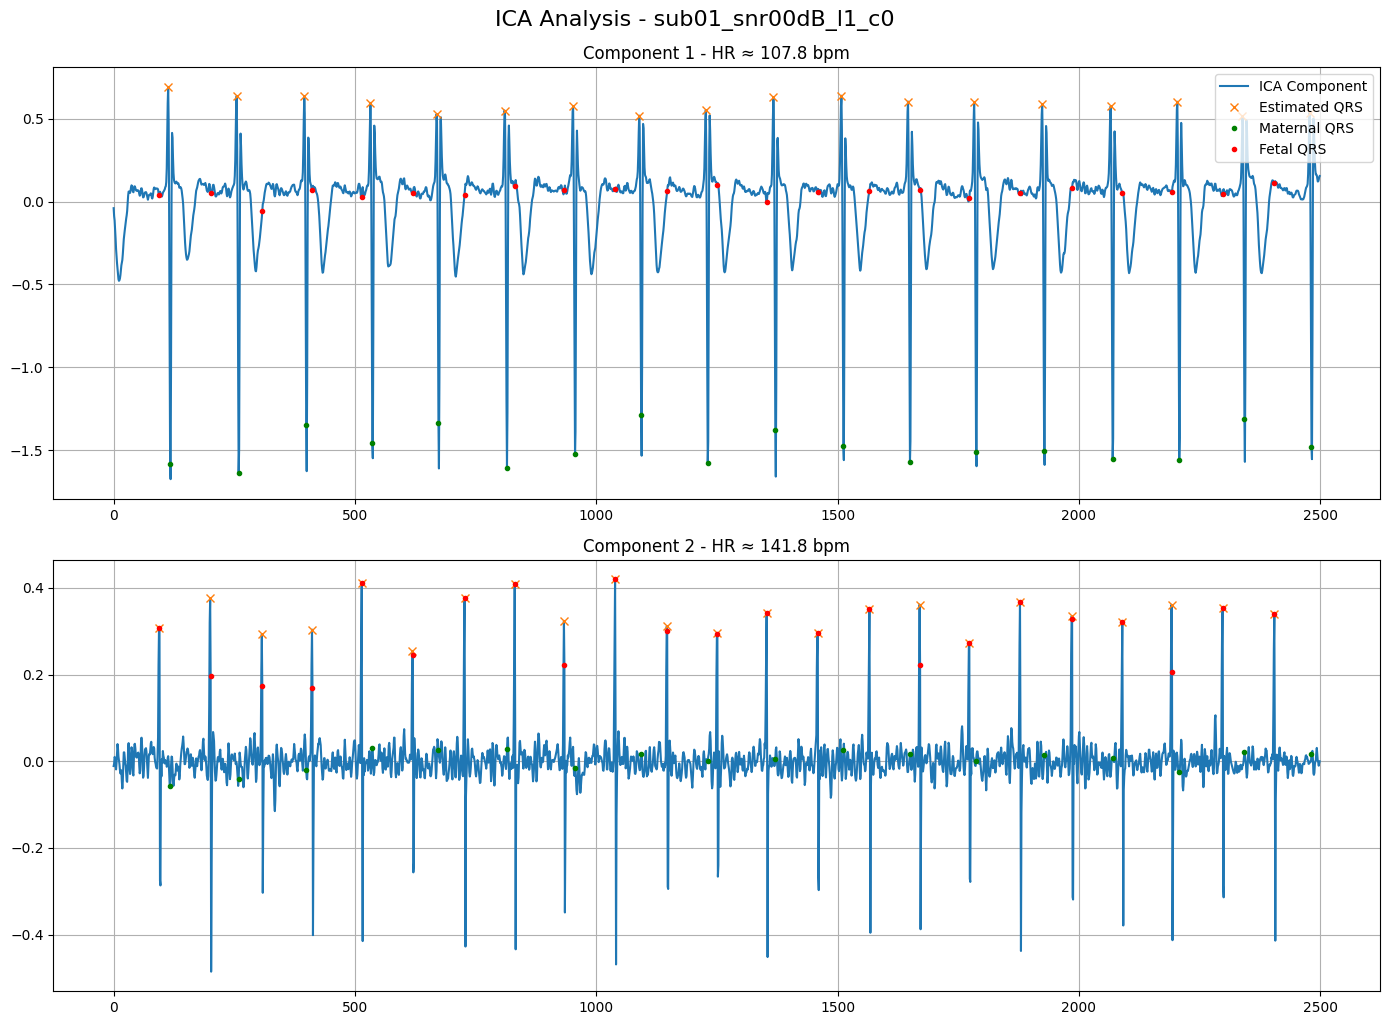

In [56]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import pearsonr

# Subject and level setup
subject = 'sub01'
level = 'l1'
record_base = f"{subject}_snr00dB_{level}_c0"
combination1_path = os.path.join('combined_signals', f"{subject}_{level}_c0_combination1")
combination2_path = os.path.join('combined_signals', f"{subject}_{level}_c0_combination2")
ica_path = os.path.join('ica_outputs', f"{subject}_{level}_c0_ica.npy")

# Load combination1 to get sampling frequency
combination1_rec = wfdb.rdrecord(combination1_path)
fs = combination1_rec.fs

# Load ICA components
separated_signals = np.load(ica_path)

# Load original signals to compute correlation
sub_folder = os.path.join('./', subject, level)
fetal = wfdb.rdrecord(os.path.join(sub_folder, f"{record_base}_fecg1"))
maternal = wfdb.rdrecord(os.path.join(sub_folder, f"{record_base}_mecg"))
f_ecg = fetal.p_signal[:, 0]
m_ecg = maternal.p_signal[:, 0]

# Load ground truth QRS annotations
fecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{record_base}_fecg1"), 'qrs')
mecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{record_base}_mecg"), 'qrs')
fecg_rpeaks = fecg_ann.sample
mecg_rpeaks = mecg_ann.sample

# Ground truth HR
true_fecg_hr = compute_hr(fecg_rpeaks, fs)
true_mecg_hr = compute_hr(mecg_rpeaks, fs)
print("\n--- Ground Truth Heart Rates ---")
print(f"Fetal HR:    {true_fecg_hr:.1f} bpm")
print(f"Maternal HR: {true_mecg_hr:.1f} bpm")

# ICA HR Estimation
estimated_peaks = []
estimated_hrs = []

print("\n--- ICA Component HR Estimation ---")
for i in range(separated_signals.shape[1]):  # Dynamically handle the number of components
    sig = separated_signals[:, i]
    peaks, _ = find_peaks(sig, distance=int(0.4 * fs))  # ~150 bpm
    hr = compute_hr(peaks, fs)
    estimated_peaks.append(peaks)
    estimated_hrs.append(hr)
    print(f"Component {i+1}: HR ≈ {hr:.1f} bpm")

# Correlation with ground truth waveforms
print("\n--- Correlation with Ground Truth Signals ---")
for i in range(separated_signals.shape[1]):
    print(f"\nComponent {i+1}:")
    for label, original in zip(['Maternal', 'Fetal'], [m_ecg, f_ecg]):
        r, _ = pearsonr(separated_signals[:len(original), i], original)
        print(f"  Correlation with {label} ECG: r = {r:.3f}")

# Plot first 10 seconds
samples_to_plot = fs * 10
plt.figure(figsize=(14, 10))
for i in range(separated_signals.shape[1]):
    plt.subplot(separated_signals.shape[1], 1, i + 1)
    sig = separated_signals[:samples_to_plot, i]
    plt.plot(sig, label='ICA Component')
    # Estimated peaks
    peaks = estimated_peaks[i]
    peaks = peaks[peaks < samples_to_plot]
    plt.plot(peaks, sig[peaks], 'x', label='Estimated QRS')
    # Ground truth
    gt_m = mecg_rpeaks[mecg_rpeaks < samples_to_plot]
    gt_f = fecg_rpeaks[fecg_rpeaks < samples_to_plot]
    plt.plot(gt_m, sig[gt_m], 'go', markersize=3, label='Maternal QRS')
    plt.plot(gt_f, sig[gt_f], 'ro', markersize=3, label='Fetal QRS')
    plt.title(f"Component {i+1} - HR ≈ {estimated_hrs[i]:.1f} bpm")
    if i == 0:
        plt.legend(loc='upper right')
    plt.grid()

plt.tight_layout()
plt.suptitle(f"ICA Analysis - {record_base}", fontsize=16, y=1.02)
plt.show()